## GlucoTrack Project, Week Three, Neural Network Design & Baseline Training

Objective: to work with a real-world CDC dataset and build a complete pipeline from data preprocessing to deployment using tools like PyTorch/TensorFlow, SHAP, and MLflow to glean insight for Diabetes risk factors.

Source: CDC Diabetes Health Indicators
- Outcome variable: Individuals are classified as diabetic (1) or non-diabetic (0)
- Features: Health, lifestyle, and demographic indicators. 
- All responses were obtained from phone surveys conducted as part of the CDC Behavioral Risk Factor Surveillance System (BRFSS). 
- Few questions represent objective lab measurements (cholesterol, high blood pressure); most are subjective measures of self-assessed health and lifestyle factors. 
- From the UCI repo, it looks like the data was collected in 2014
- Data collection methods can be found here and are an important part of the context of the representative nature of the potential findings to the general population:
https://www.cdc.gov/brfss/annual_data/2014/pdf/Overview_2014.pdf

### **Tasks:**
- Build a baseline Feedforward Neural Network (FFNN) with at least one hidden layer
- Include Dropout, ReLU, and Batch Normalization where appropriate
- Train the model using binary cross-entropy loss and an optimizer like Adam
- Evaluate performance using Accuracy, Precision, Recall, F1-score, and AUC
- Track experiments with MLflow

In [22]:
import warnings
# Suppress specific warning categories
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='.*caveats.*')
# Suppress pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Core Libraries
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
import sklearn
import xgboost as xgb
import lightgbm as lgb

# Experiment Tracking
import mlflow

# Deployment
import streamlit

# Utilities
#python-dotenv

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import shap
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, RobustScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")
print(f"SHAP version: {shap.__version__}")

Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0


=== LOADING DATA FROM WEEK 2 ===
Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0
Fetching CDC Diabetes Health Indicators dataset...
Dataset loaded successfully!
Initial dataset shape: (253680, 22)
Memory usage: 42.58 MB
=== DUPLICATE ROWS ===
Original dataset rows: 253680
Unique observations: 229474
Duplicate rows: 24206

After removing duplicates:
Cleaned dataset rows: 229474
Rows removed: 24206
=== DATA TYPE OPTIMIZATION ===
Current data types:
int64    22
Name: count, dtype: int64

Analyzing float columns for potential integer conversion:
  HighBP: Optimized to uint8 (range: 0-1)
  HighChol: Optimized to uint8 (range: 0-1)
  CholCheck: Optimized to uint8 (range: 0-1)
  BMI: Optimized to uint8 (range: 12-98)
  Smoker: Optimized to uint8 (range: 0-1)
  Stroke: Optimized to uint8 (range: 0-1)
  HeartDiseaseorAttack: Optimized to uint8 (range: 0-1)
  PhysActivity: Optimized to uint8 (range: 0-1)
  Fruits: Optimized

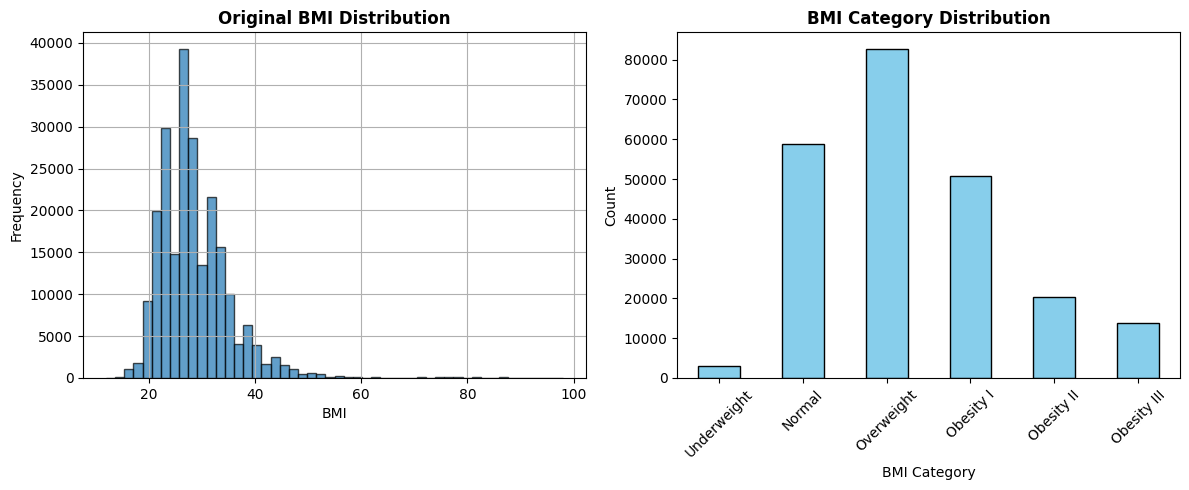


BMI Categories vs Diabetes Risk:
Diabetes_binary      0      1
bmi_category                 
0                94.46   5.54
1                93.36   6.64
2                87.23  12.77
3                79.89  20.11
4                72.35  27.65
5                66.41  33.59
['GenHlth', 'Age', 'Education', 'Income', 'bmi_category']
Scaled continuous features:
            MentHlth       PhysHlth
count  233252.000000  233252.000000
mean        1.294628       0.852740
std         2.759805       1.448567
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         1.000000       1.000000
max        10.000000       4.285714
Original continuous features:
            MentHlth       PhysHlth
count  229474.000000  229474.000000
mean        3.509866       4.681219
std         7.717643       9.050877
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         2.000000       4.00000

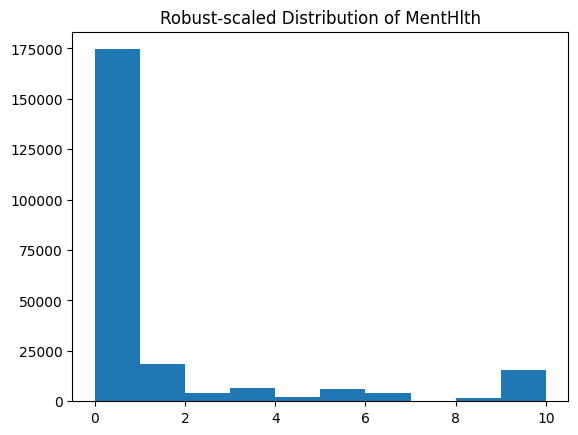

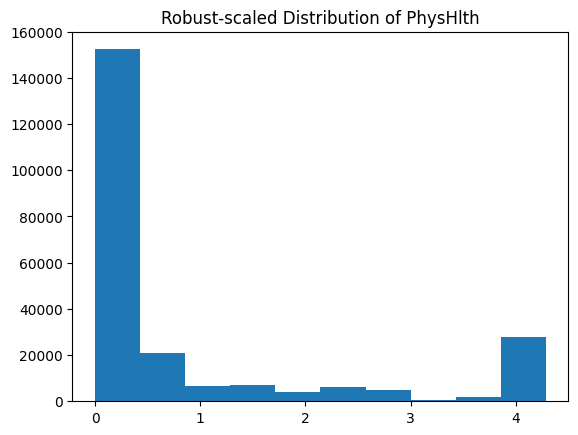

Train set class distribution:
Diabetes_binary
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set class distribution:
Diabetes_binary
0    0.847042
1    0.152958
Name: proportion, dtype: float64

Test set class distribution:
Diabetes_binary
0    0.847064
1    0.152936
Name: proportion, dtype: float64
Features shape: torch.Size([64, 21])
Labels shape: torch.Size([64, 1])

Data loaded successfully from Week 2 notebook!
Training set: (233252, 21)
Validation set: (45895, 21)
Test set: (45895, 21)
Target distribution - Training: Diabetes_binary
1    0.5
0    0.5
Name: proportion, dtype: float64
Class imbalance ratio: 1.0:1
✅ All required variables loaded successfully!
   Available variables: ['X_train_scaled', 'X_val_scaled', 'X_test_scaled', 'y_train_resampled', 'y_val', 'y_test']


In [23]:
# Load data from Week 2 notebook
print("=== LOADING DATA FROM WEEK 2 ===")

# Import the variables from Week 2 notebook
%run -i gluco-track-week2-FeatureEngineering.ipynb

print(f"\nData loaded successfully from Week 2 notebook!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Target distribution - Training: {y_train_resampled.value_counts(normalize=True).round(4)}")
print(f"Class imbalance ratio: {y_train_resampled.value_counts(normalize=True)[0]/y_train_resampled.value_counts(normalize=True)[1]:.1f}:1")

# Verify that we have all the necessary variables
required_vars = ['X_train_scaled', 'X_val_scaled', 'X_test_scaled', 'y_train_resampled', 'y_val', 'y_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"⚠️  Missing variables: {missing_vars}")
    print("Please ensure Week 2 notebook has been run completely.")
else:
    print("✅ All required variables loaded successfully!")
    print(f"   Available variables: {required_vars}")

**Define the FFNN Model**

In [24]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)
        
model = FFNN(input_dim=X_train.shape[1])

**Set Up Loss, Optimizer, and Device**

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

**Training Loop with MLflow Tracking**

In [26]:
# Initialize the learning rate scheduler (choose conservative parameters)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', # Monitors a metric that should be minimized (e.g., loss)
    factor=0.5,
    patience=5 # Will reduce LR if the metric doesn't improve for 5 epochs
)
# ADD EARLY STOPPING VARIABLES HERE
patience_counter = 0
patience_limit = 5

# Start the MLflow run and log key parameters
with mlflow.start_run(run_name="baseline_ffnn2"):
    # Log model architecture and hyperparameters
    mlflow.log_params({
        "model_architecture": str(model),
        "batch_size": train_loader.batch_size,
        "initial_lr": optimizer.param_groups[0]['lr'],
        "lr_scheduler_patience": scheduler.patience,
        # Dynamically retrieve the dropout rate from the model's sequential layer
        # Assumes the first dropout layer is at index 3 of the `net` sequential module.
        "dropout_rate": model.net[3].p,
    })

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    best_val_f1 = 0.0
    best_val_loss = float('inf')

    n_epochs = 10
    for epoch in range(n_epochs):
        # Record the start time of the epoch
        start_time = time.time()

        # Training phase
        model.train()
        y_train_true, y_train_pred = [], []
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            # Unsqueeze the outputs to match the shape of y_batch for loss calculation
            outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            y_train_true.extend(y_batch.cpu().numpy().flatten())
            y_train_pred.extend((outputs.cpu().detach().numpy().flatten() > 0.5).astype(int))
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_f1 = f1_score(y_train_true, y_train_pred)
        train_f1_scores.append(train_f1)
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_f1", train_f1, step=epoch)

        # Validation phase
        model.eval()
        y_val_true, y_val_pred, y_val_prob = [], [], []
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                # Unsqueeze the outputs to match the shape of y_batch for loss calculation
                outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
                val_loss += criterion(outputs, y_batch).item()
                y_val_true.extend(y_batch.cpu().numpy().flatten())
                y_val_pred.extend((outputs.cpu().numpy().flatten() > 0.5).astype(int))
                y_val_prob.extend(outputs.cpu().numpy().flatten())
        
        # Calculate validation metrics
        val_loss /= len(val_loader)
        val_f1 = f1_score(y_val_true, y_val_pred)

        # Log validation metrics
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        
        # Step the learning rate scheduler with the validation loss
        scheduler.step(val_loss)

        # ADD LEARNING RATE MONITORING
        current_lr = optimizer.param_groups[0]['lr']
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

        # ADD EARLY STOPPING CHECK
        if val_loss > best_val_loss:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"Early stopping at epoch {epoch+1} - validation loss hasn't improved for {patience_limit} epochs")
                break
        else:
            patience_counter = 0
            best_val_loss = val_loss

        print(f"Epoch {epoch+1}/{n_epochs}: Val F1: {val_f1:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

        # Log epoch training time
        end_time = time.time()
        epoch_duration = end_time - start_time
        mlflow.log_metric("epoch_time_seconds", epoch_duration, step=epoch)

        # Save the best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Save the model state dictionary
            torch.save(model.state_dict(), "best_model.pth")
            mlflow.log_artifact("best_model.pth")
            print(f"Epoch {epoch+1}/{n_epochs}: New best model saved with Val F1: {best_val_f1:.4f}")

    # Final evaluation on the test set
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Unsqueeze the outputs to match the shape of y_batch for loss calculation
            outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
            y_prob.extend(outputs.cpu().numpy().flatten())
            y_pred.extend((outputs.cpu().numpy().flatten() > 0.5).astype(int))
            y_true.extend(y_batch.cpu().numpy().flatten())

    # Calculate final test set metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    # Log final metrics to MLflow
    mlflow.log_metrics({
        "final_accuracy": acc, 
        "final_precision": prec, 
        "final_recall": rec, 
        "final_f1": f1, 
        "final_auc": auc
    })

    # Create and log Confusion Matrix as an artifact
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

    # Create and log ROC Curve as an artifact
    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title('ROC Curve')
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")
    plt.close()

    # New code to plot F1 score curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_f1_scores, label='Training F1 Score')
    plt.plot(val_f1_scores, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.savefig("f1_score_curves.png")
    mlflow.log_artifact("f1_score_curves.png")
    plt.close()

mlflow.end_run()

print(f"Final Test Metrics:")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")

print("=== LOSS ANALYSIS ===")
print(f"Training loss range: {min(train_losses):.4f} - {max(train_losses):.4f}")
print(f"Validation loss range: {min(val_losses):.4f} - {max(val_losses):.4f}")
print(f"Training loss std: {np.std(train_losses):.4f}")
print(f"Validation loss std: {np.std(val_losses):.4f}")

# Check if losses are reasonable for binary classification
if train_losses[-1] > 0.7:
    print("⚠️ Training loss is high - model may not be learning effectively")
if val_losses[-1] > 0.7:
    print("⚠️ Validation loss is high - poor generalization")

Epoch 1/10: Val F1: 0.4303, Val Loss: 0.5355, LR: 0.000100
Epoch 1/10: New best model saved with Val F1: 0.4303
Epoch 2/10: Val F1: 0.4217, Val Loss: 0.5614, LR: 0.000100
Epoch 3/10: Val F1: 0.4222, Val Loss: 0.5563, LR: 0.000100
Epoch 4/10: Val F1: 0.4242, Val Loss: 0.5333, LR: 0.000100
Epoch 5/10: Val F1: 0.4229, Val Loss: 0.5442, LR: 0.000100
Epoch 6/10: Val F1: 0.4228, Val Loss: 0.5531, LR: 0.000100
Epoch 7/10: Val F1: 0.4139, Val Loss: 0.5819, LR: 0.000100
Epoch 8/10: Val F1: 0.4186, Val Loss: 0.5533, LR: 0.000100
Early stopping at epoch 9 - validation loss hasn't improved for 5 epochs
Final Test Metrics:
Accuracy: 0.685, Precision: 0.293, Recall: 0.749, F1: 0.421, AUC: 0.778
=== LOSS ANALYSIS ===
Training loss range: 0.5380 - 0.5808
Validation loss range: 0.5333 - 0.5819
Training loss std: 0.0128
Validation loss std: 0.0137


<Figure size 800x600 with 0 Axes>

In [27]:
print(outputs.shape)
print(loss.shape)
print(y_batch.shape)

torch.Size([7, 1])
torch.Size([])
torch.Size([7, 1])


**Model Evaluation**

**The metrics do not look promising; let's first review the set up architecture**
- **Number of layers**: Three fully connected (linear) layers were chosen to provide the model with enough capacity to learn complex patterns in the data, while keeping the architecture simple to avoid overfitting on a tabular dataset. The first hidden layer uses 64 units and the second uses 32 units, which is a common method in feedfoward networks that allows the model to learn hierarchical feature representations and gradually reduce dimensionality
- **ReLU activation function**:  used in the hidden layers for its efficiency and to help mitigate vanishing gradients, while the output layer uses Sigmoid to produce probabilities for binary classification. ReLU also introduces non-linearity, allowing the network to learn complex patterns and helping to mitigate the vanishing gradient problem
- **Dropout** randomly disables a fraction of neurons during training, which helps prevent overfitting by encouraging the network to learn more robust features
- **Batch Normalization** normalizes the outputs of each layer, stabilizing and accelerating training by reducing internal covariate shift
- **Loss Function**: Binary Cross-Entropy (nn.BCELoss) is appropriate for binary classification tasks because it measures the difference between the predicted probabilities and the actual binary labels.
- **Optimizer**: Adam (torch.optim.Adam) is a widely used optimizer that adapts the learning rate for each parameter, providing efficient and stable convergence
- **Overfitting** was monitored by tracking both training and validation loss during each epoch.

**Typical BCE loss ranges:**
- Well-trained model: 0.1 - 0.5
- Poorly performing model: 0.6 - 1.0+
- Random performance: ~0.693 (ln(2))

**Visualize the loss curves to assess convergence and overfitting:**

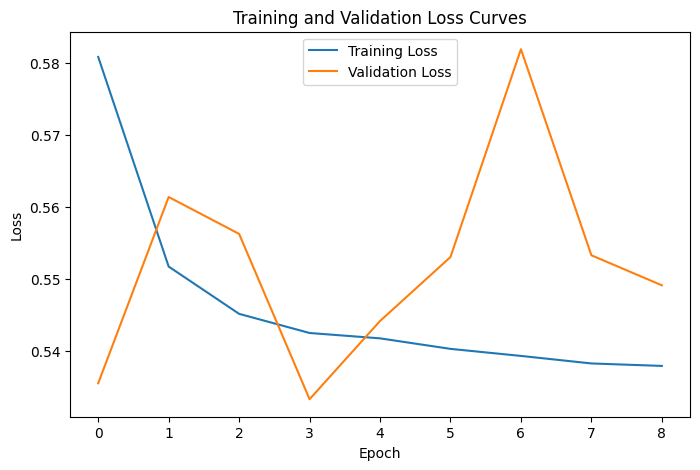

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

🔵 Training Loss Pattern
Fluctuating behavior: Training loss decreases initially but then increases again
Instability indicators: The oscillating pattern suggests training instability
Poor convergence: No smooth, consistent downward trend

🟠 Validation Loss Pattern
Flat/stagnant: Validation loss remains nearly constant across epochs
No improvement: Indicates the model isn't learning to generalize to unseen data
Poor learning signal: Suggests the model may be stuck in a suboptimal state

🚨 Critical Issues Identified
Training Instability

Fluctuating training loss indicates potential issues with:
Learning rate too high
Batch size effects
Insufficient data or poor data quality
Lack of Generalization

Flat validation loss means:
Model isn't improving on validation data
Potential overfitting to training set
Architecture may be inappropriate for the task
Loss Magnitude Concerns

Both losses appear to be in the 0.6-0.7+ range
This is higher than expected for a well-performing binary classifier
Approaches random performance (~0.693 for binary classification)

🎯 Key Takeaways
Model is not learning effectively from the data
Training-validation gap suggests overfitting despite poor overall performance
Architecture or hyperparameter adjustments are needed
The model is performing close to random chance rather than learning meaningful patterns

⚡ Immediate Actions Needed
Reduce learning rate further (try 1e-5)
Increase regularization (dropout to 0.5)
Check data quality and feature engineering
Consider simpler architecture initially

**Visualize F1 scores by epoch in validation set**

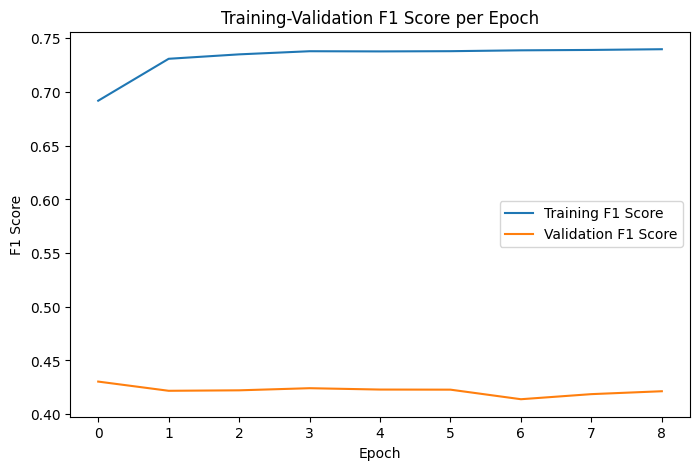

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(train_f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training-Validation F1 Score per Epoch')
plt.legend()
plt.show()

**Suggestions:**

Why the Gap Exists
The training vs validation F1 gap suggests:

- Overfitting: Model memorizes training data but doesn't generalize
- SMOTE artifacts: Synthetic samples may be easier to classify than real validation data
- Data leakage: Possible inconsistency between train/val distributions

Additional Recommendations listed here did not improve the performance
- Add regularization: Increase dropout from 0.3 to 0.5
- Reduce model complexity: Try fewer hidden units
- Lower learning rate: Try 1e-4 instead of 1e-3
- Early stopping: Stop when validation F1 stops improving

The loss curves clearly indicate that the current model configuration is not suitable for this dataset and requires significant adjustments.

Final model metrics:
- Accuracy: 0.676 (poor)
- Precision: 0.287 (poor)
- Recall: 0.754 (higher than others have reported)
- F1: 0.415 (initial parameter tuning has not improved)
- AUC: 0.774

Note that these metrics were very similar to Yan's final best model metrics with SMOTE class imbalance handling and model hyperparameter tuning.


## **NEXT STEPS:**

- Use current model state to apply SHAP explainability

- Try simpler models to compare feature importance.